In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from PIL import Image

# Group 3: Tian Xia, Hongxin Song, Zekun Li, Haomiao Tang, Yuebin Mao, Chenxin Yi
### The final presentation
https://www.youtube.com/watch?v=Yrk_VesM-as

# Import dataset


In [ ]:
!gdown -qq https://drive.google.com/file/d/1SOAA-xo2G4O7ztq7lCrvwvGOIKbfCsyH/view?usp=sharing --fuzzy
!gdown -qq https://drive.google.com/file/d/192yOSSxfrVekoQRP6OJl7SZAyn2BBIsh/view?usp=sharing --fuzzy
!unzip FER.zip -d ./FER

Streaming output truncated to the last 5000 lines.
  inflating: ./FER/train/sad/Training_65242339.jpg  
  inflating: ./FER/train/sad/Training_65267116.jpg  
  inflating: ./FER/train/sad/Training_65275626.jpg  
  inflating: ./FER/train/sad/Training_6529266.jpg  
  inflating: ./FER/train/sad/Training_65329617.jpg  
  inflating: ./FER/train/sad/Training_65338712.jpg  
  inflating: ./FER/train/sad/Training_65338797.jpg  
  inflating: ./FER/train/sad/Training_65387162.jpg  
  inflating: ./FER/train/sad/Training_65404494.jpg  
  inflating: ./FER/train/sad/Training_65426218.jpg  
  inflating: ./FER/train/sad/Training_65430136.jpg  
  inflating: ./FER/train/sad/Training_65437377.jpg  
  inflating: ./FER/train/sad/Training_6545735.jpg  
  inflating: ./FER/train/sad/Training_65463385.jpg  
  inflating: ./FER/train/sad/Training_65473985.jpg  
  inflating: ./FER/train/sad/Training_65502829.jpg  
  inflating: ./FER/train/sad/Training_65505359.jpg  
  inflating: ./FER/train/sad/Training_65508578.jpg

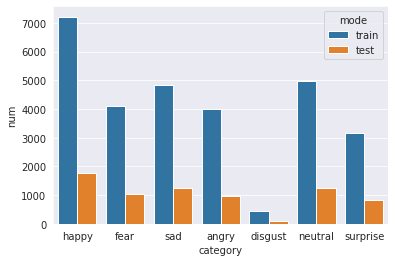

In [ ]:
train_dir = './FER/train/'
test_dir = './FER/test/'

img_h, img_w = 48, 48
classes = 7

cnt_list = list()

for expression in os.listdir(train_dir):
    img_path = os.path.join(train_dir, expression, '*.jpg')
    n = len(glob.glob(img_path))
    cnt_list.append({"category":expression,'mode':'train','num':n})

for expression in os.listdir(test_dir):
    img_path = os.path.join(test_dir, expression, '*.jpg')
    n = len(glob.glob(img_path))
    cnt_list.append({"category":expression,'mode':'test','num':n})

df = pd.DataFrame(cnt_list)
sns.set_style("darkgrid")
sns.barplot(data=df, x='category', y='num', hue='mode')

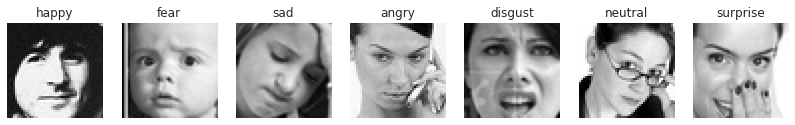

In [ ]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
  img_path = glob.glob(os.path.join(train_dir, expression, '*.jpg'))
  num_images = len(img_path)
  img = Image.open(img_path[np.random.randint(num_images)]).convert('L')
  plt.subplot(1,7,i)
  plt.imshow(img, cmap='gray')
  plt.title(expression)
  plt.axis('off')
  i += 1
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                   zoom_range=0.3,
                   horizontal_flip=True,
                   vertical_flip=True,
                   rotation_range=10)

training_set = train_datagen.flow_from_directory(train_dir,batch_size=64,
                           target_size=(48,48),shuffle=True,
                           color_mode='grayscale',
                           class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,batch_size=64,
                        target_size=(48,48),
                        shuffle=False,
                        color_mode='grayscale',
                        class_mode='categorical')

training_set_rgb = train_datagen.flow_from_directory(train_dir,batch_size=64,
                           target_size=(48,48),shuffle=True,
                           color_mode='rgb',
                           class_mode='categorical')

test_set_rgb = test_datagen.flow_from_directory(test_dir,batch_size=64,
                        target_size=(48,48),
                        shuffle=False,
                        color_mode='rgb',
                        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# define the network

In [ ]:
model = tf.keras.models.Sequential(name='FER')   
input_size = (48,48,1)
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(classes, activation='softmax'))

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

#Compliling the model
fer_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9,nesterov=True)
scheduler = ReduceLROnPlateau(mode='max', factor=0.75, patience=5, verbose=True)
model.compile(optimizer=fer_optimizer,loss='categorical_crossentropy',metrics=METRICS)
model.summary()

Model: "FER"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_8 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_9 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                               

# train model

In [ ]:
hist = model.fit(x=training_set,validation_data=test_set,epochs=60,callbacks=[scheduler])

NameError: ignored

Text(0.5, 0.98, 'FER Training')

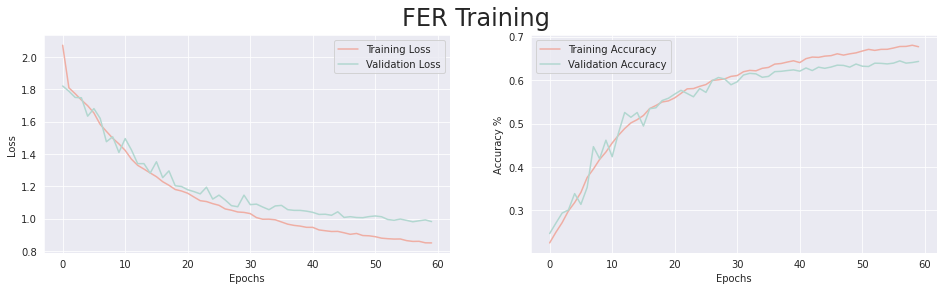

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0].plot(hist.history['loss'], color='#EFAEA4', label='Training Loss')
ax[0].plot(hist.history['val_loss'],
           color='#B2D7D0', label='Validation Loss')
ax[1].plot(hist.history['accuracy'],
           color='#EFAEA4', label='Training Accuracy')
ax[1].plot(hist.history['val_accuracy'],
           color='#B2D7D0', label='Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %')
fig.suptitle('FER Training', fontsize=24)

In [ ]:
model.save_weights('fernet_bestweight.h5')

# load model

In [ ]:
model = tf.keras.models.Sequential()   
input_size = (48,48,1)
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(classes, activation='softmax'))

model.load_weights('fernet_bestweight.h5')
#Compliling the model
fer_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9,nesterov=True)
scheduler = ReduceLROnPlateau(mode='max', factor=0.75, patience=5, verbose=True)
model.compile(optimizer=fer_optimizer,loss='categorical_crossentropy',metrics='accuracy')
acc = model.evaluate(test_set)[1]
print(acc)

113/113 [==============================] - 13s 24ms/step - loss: 1.1820 - accuracy: 0.6743
0.6742825508117676


# Baseline Model Results Visualizations

In [ ]:
# Take a look at the images, predicted labels, and true labels
y_prob = model.predict_generator(test_set)
y_pred = np.argmax(y_prob, axis = 1)
y_true = test_set.labels
class_labels = list(test_set.class_indices.keys())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [ ]:
test_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true,y_pred)

0.674282529952633

### Confusion Matrix and Classification Report

In [ ]:
# Generate a report based on the results of claasification on different classes
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

       angry       0.59      0.63      0.61       958
     disgust       0.75      0.60      0.67       111
        fear       0.53      0.51      0.52      1024
       happy       0.85      0.87      0.86      1774
     neutral       0.65      0.61      0.63      1233
         sad       0.55      0.57      0.56      1247
    surprise       0.79      0.79      0.79       831

    accuracy                           0.67      7178
   macro avg       0.67      0.65      0.66      7178
weighted avg       0.67      0.67      0.67      7178



Text(159.0, 0.5, 'Truth')

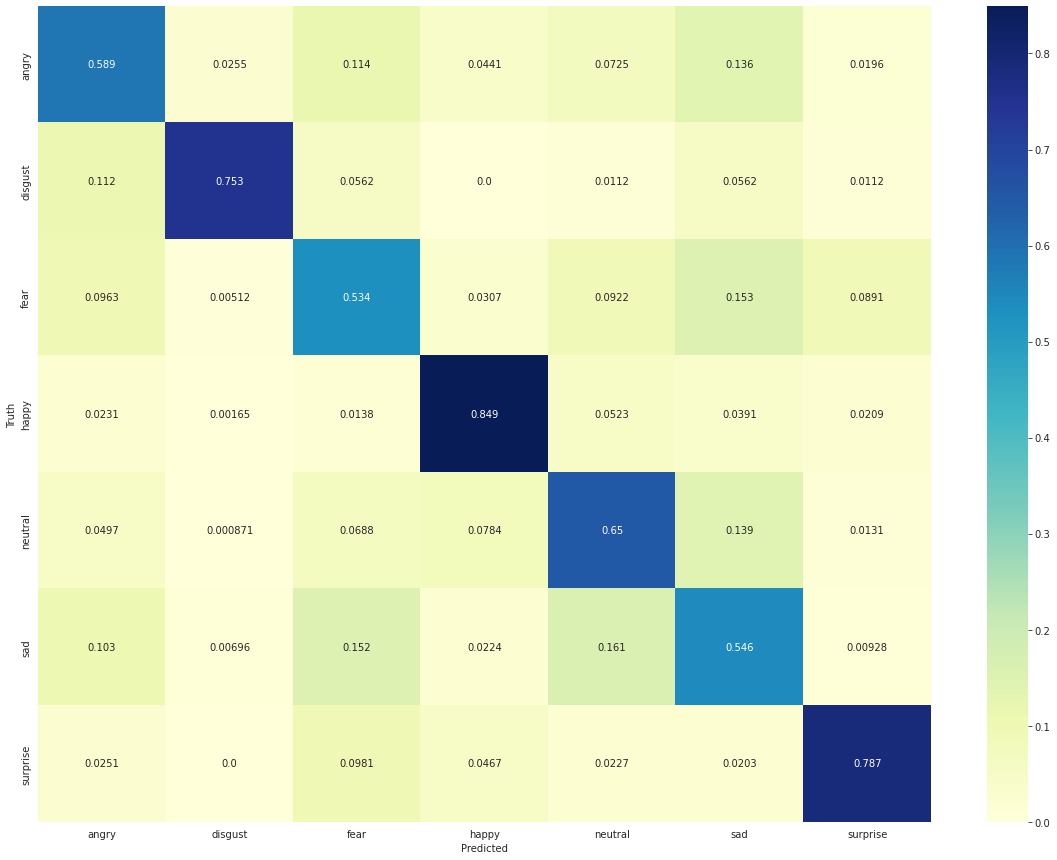

In [ ]:
#Plot the confusion metrics to take a look at the performance of the model on different classes
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_pred, y_true)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize = (20, 15))
sns.heatmap(cmn, annot = True, fmt = '.3', xticklabels = class_labels,
            yticklabels = class_labels,cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Gradcam and Saliency Map 

## prep

In [ ]:
!pip install tf-keras-vis tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.7 MB/s 


In [ ]:
cor = []
incor = []
for i in range(len(y_pred)):
  if y_pred[i] == y_true[i]:
    cor.append(i)
  else:
    incor.append(i)  

In [ ]:
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.gradcam import Gradcam
from matplotlib import cm
def plot_generation(md,label,layer,correct):
  score = CategoricalScore(y_true[label].tolist())
  index = int(label/64)
  input = test_set[index][0][label-index*64]

  # Create Saliency object.
  saliency = Saliency(md,
                    model_modifier=ReplaceToLinear(),
                    clone=True)

  # Generate saliency map with smoothing that reduce noise by adding noise
  saliency_map = saliency(score,
                        input,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.2) # noise spread level.

  # Create Gradcam object
  gradcam = Gradcam(md,
                  model_modifier=ReplaceToLinear(),
                  clone=True)

  # Generate heatmap with GradCAM
  cam = gradcam(score,
              input,
              penultimate_layer = md.layers[layer].name)

  heatmap = np.uint8(cm.jet(cam[0])[..., :3]*255)
  img = input.reshape(48,48)
  if correct == True:
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    ax[0].imshow(img)
    ax[0].axis('off')
    ax[0].set_title('Original Image: '+class_labels[y_true[label]], y=-0.2)
    ax[1].imshow(saliency_map[0], cmap='jet')
    ax[1].axis('off')
    ax[1].set_title('Saliency Map: '+class_labels[y_pred[label]], y=-0.2)
    ax[2].imshow(img)
    ax[2].imshow(heatmap, cmap='jet',alpha=0.5)
    ax[2].axis('off')
    ax[2].set_title('GradCAM: '+md.layers[layer].name+' '+class_labels[y_pred[label]], y=-0.2)
    plt.tight_layout()
    plt.show()
  else:
    score_pred = CategoricalScore([np.argmax(y_pred[index])])
    saliency_map_pred = saliency(score_pred,
                        input,
                        smooth_samples=20, # The number of calculating gradients iterations.
                        smooth_noise=0.2) # noise spread level.
    cam_pred = gradcam(score_pred,
              input,
              penultimate_layer=layer)
    heatmap_pred = np.uint8(cm.jet(cam_pred[0])[..., :3]*255)                    
    fig, ax = plt.subplots(1, 5, figsize=(20, 6))
    ax[0].imshow(img)
    ax[0].axis('off')
    ax[0].set_title('Original Image: '+class_labels[y_true[label]], y=-0.2)
    ax[1].imshow(saliency_map_pred[0], cmap='jet')
    ax[1].axis('off')
    ax[1].set_title('Saliency Map for Predicted class: '+class_labels[y_pred[label]], y=-0.2)
    ax[2].imshow(img)
    ax[2].imshow(heatmap_pred, cmap='jet',alpha=0.5)
    ax[2].axis('off')
    ax[2].set_title('GradCAM for Predicted class: '+class_labels[y_pred[label]], y=-0.2)
    ax[3].imshow(saliency_map[0], cmap='jet')
    ax[3].axis('off')
    ax[3].set_title('Saliency Map for Actual class: '+class_labels[y_true[label]], y=-0.2)
    ax[4].imshow(img)
    ax[4].imshow(heatmap, cmap='jet',alpha=0.5)
    ax[4].axis('off')
    ax[4].set_title('GradCAM for Actual class: '+class_labels[y_true[label]], y=-0.2)
    plt.tight_layout()
    plt.show()  


## Gradcam and Saliency Map for Angry class

In [ ]:
#Randomly select a correctly and incorrectly classified angry emotion image
import random
label_cor_angry = [x for x in cor if y_true[x] == 0]
label_incor_angry = [x for x in incor if y_true[x] == 0]
label_cor_a = random.choice(label_cor_angry)
label_incor_a = random.choice(label_incor_angry)

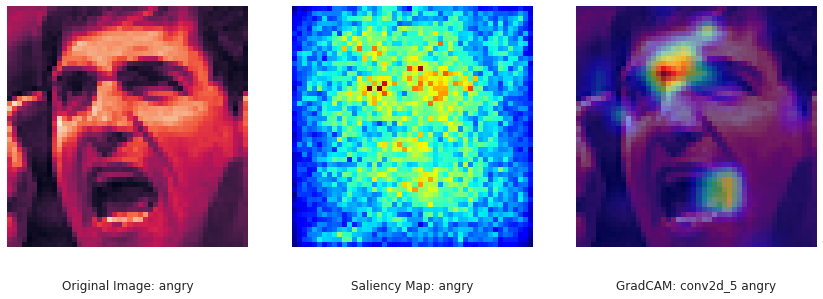

In [ ]:
plot_generation(model,label_cor_a,-14,True)

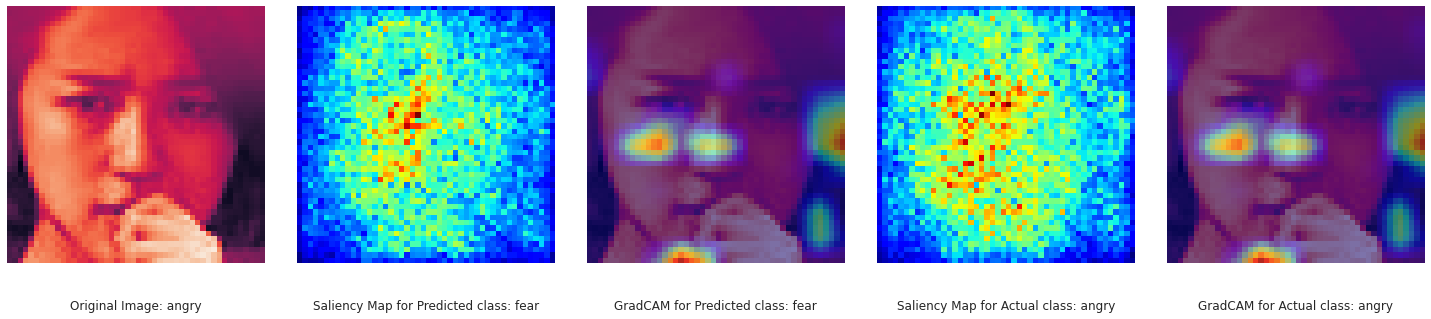

In [ ]:
plot_generation(model,label_incor_a,-14,False)

## Gradcam and Saliency Map for Disgust class

In [ ]:
#Randomly select a correctly and incorrectly classified disgust emotion image
import random
label_cor_disgust = [x for x in cor if y_true[x] == 1]
label_incor_disgust = [x for x in incor if y_true[x] == 1]
label_cor_d = random.choice(label_cor_disgust)
label_incor_d = random.choice(label_incor_disgust)


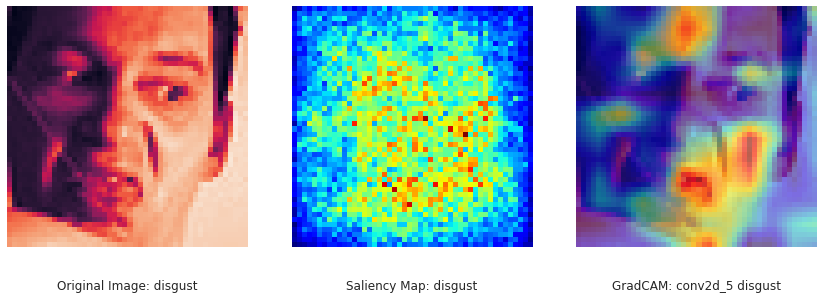

In [ ]:
plot_generation(model,label_cor_d,-14,True)

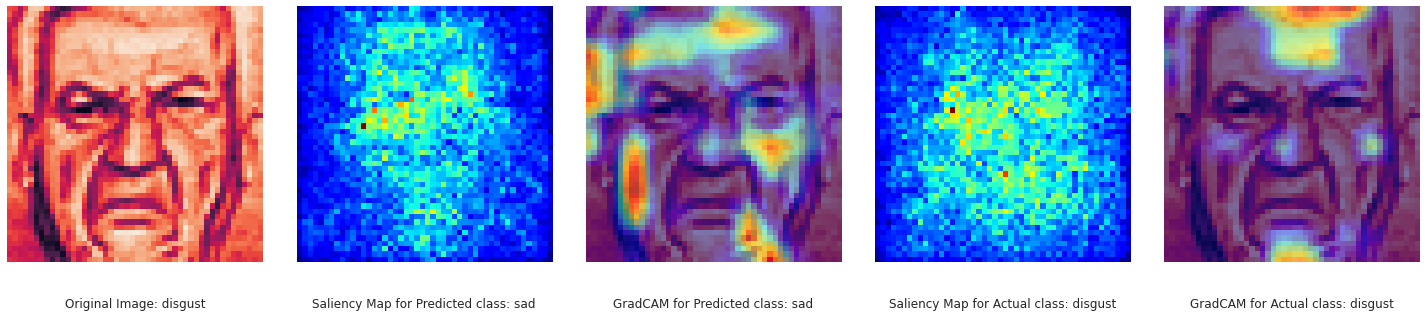

In [ ]:
plot_generation(model,label_incor_d,-14,False)

## Gradcam and Saliency Map for Fear class

In [ ]:
#Randomly select a correctly and incorrectly classified fear emotion image

label_cor_fear = [x for x in cor if y_true[x] == 2]
label_incor_fear = [x for x in incor if y_true[x] == 2]
label_cor_f = random.choice(label_cor_fear)
label_incor_f = random.choice(label_incor_fear)

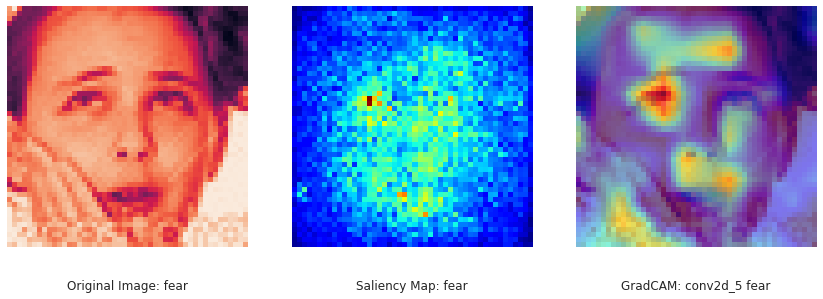

In [ ]:
plot_generation(model,label_cor_f,-14,True)

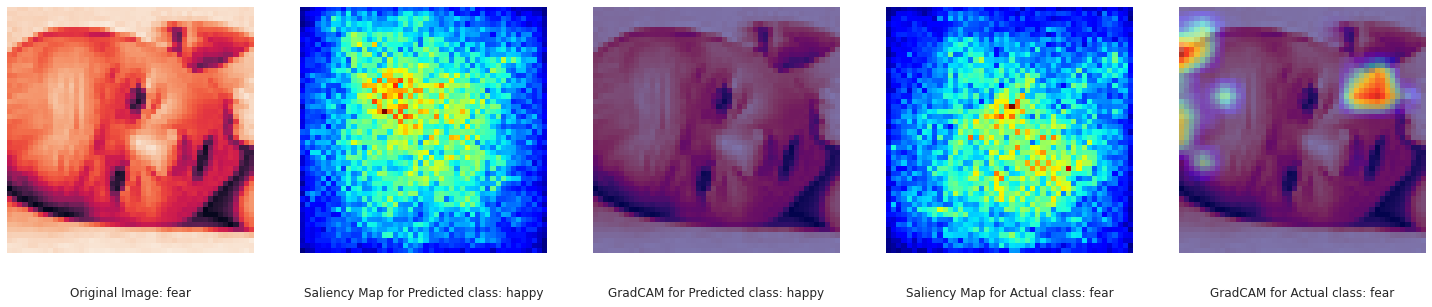

In [ ]:
plot_generation(model,label_incor_f,-14,False)

## Gradcam and Saliency Map for Happy class

In [ ]:
#Randomly select a correctly and incorrectly classified happy emotion image

label_cor_happy = [x for x in cor if y_true[x] == 3]
label_incor_happy = [x for x in incor if y_true[x] == 3]
label_cor_h = random.choice(label_cor_happy)
label_incor_h = random.choice(label_incor_happy)

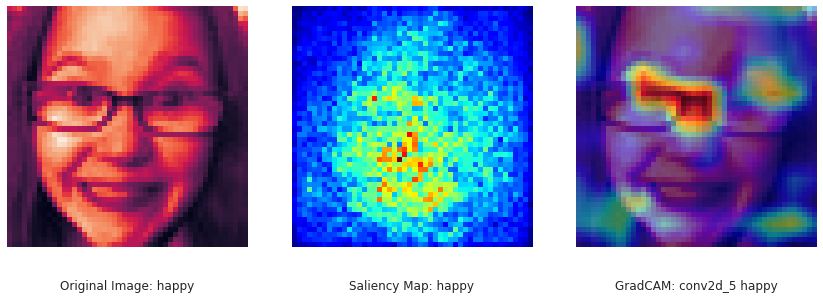

In [ ]:
plot_generation(model,label_cor_h,-14,True)

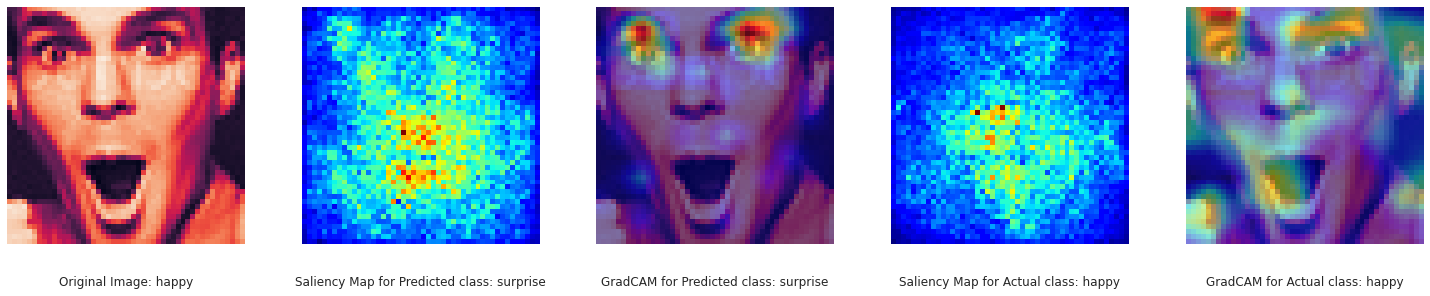

In [ ]:
plot_generation(model,label_incor_h,-14,False)

## Gradcam and Saliency Map for Neutral class

In [ ]:
#Randomly select a correctly and incorrectly classified neutral emotion image

label_cor_neutral = [x for x in cor if y_true[x] == 4]
label_incor_neutral = [x for x in incor if y_true[x] == 4]
label_cor_n = random.choice(label_cor_neutral)
label_incor_n = random.choice(label_incor_neutral)

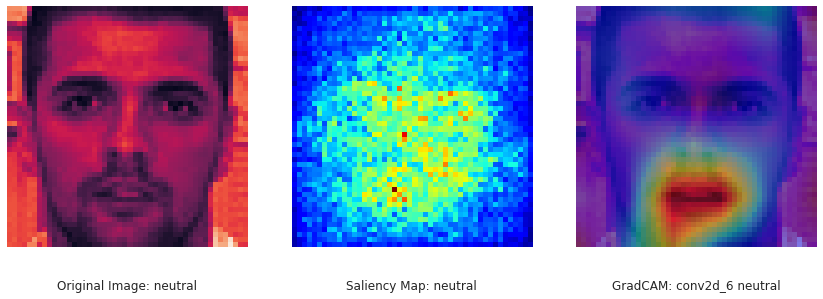

In [ ]:
plot_generation(model,label_cor_n,-11,True)

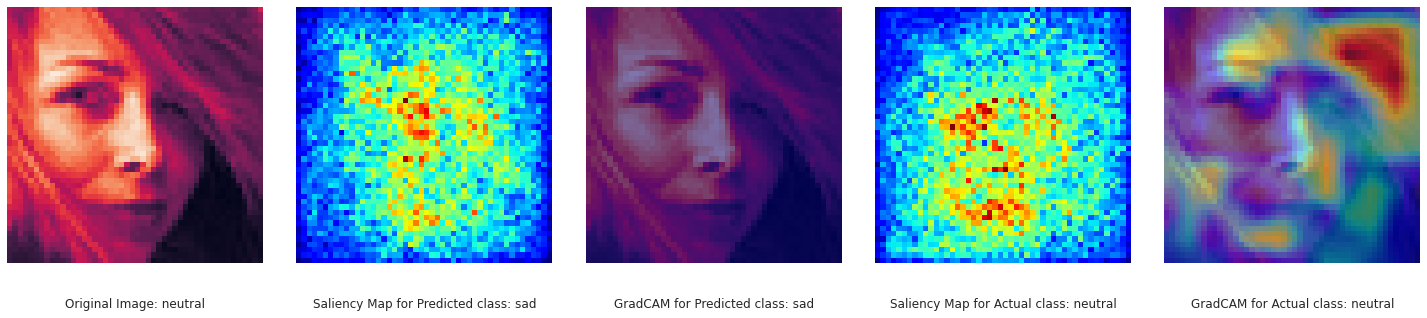

In [ ]:
plot_generation(model,label_incor_n,-14,False)

## Gradcam and Saliency Map for Sad class

In [ ]:
#Randomly select a correctly and incorrectly classified sad emotion image

label_cor_sad = [x for x in cor if y_true[x] == 5]
label_incor_sad = [x for x in incor if y_true[x] == 5]
label_cor_s = random.choice(label_cor_sad)
label_incor_s = random.choice(label_incor_sad)

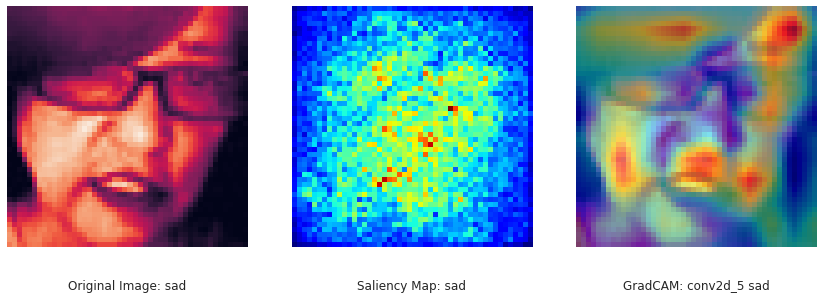

In [ ]:
plot_generation(model,label_cor_s,-14,True)

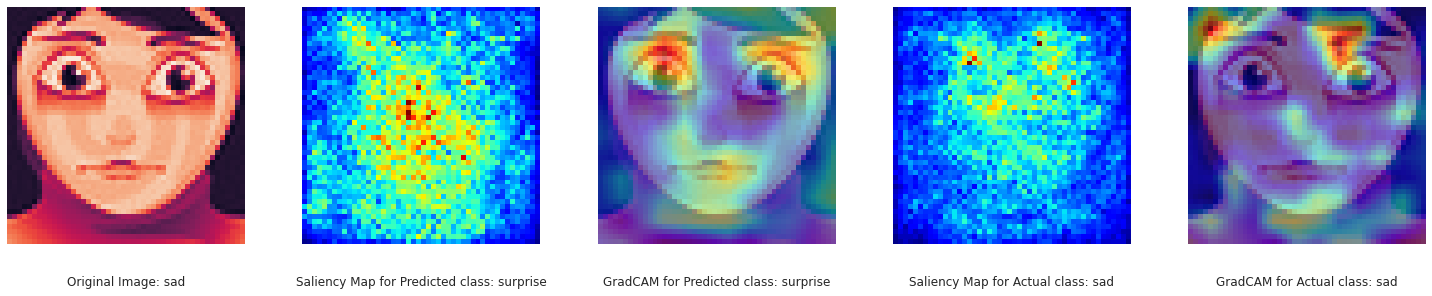

In [ ]:
plot_generation(model,label_incor_s,-14,False)

## Gradcam and Saliency Map for Surprise class

In [ ]:
#Randomly select a correctly and incorrectly classified surprise emotion image

label_cor_surprise = [x for x in cor if y_true[x] == 6]
label_incor_surprise = [x for x in incor if y_true[x] == 6]
label_cor_p = random.choice(label_cor_surprise)
label_incor_p = random.choice(label_incor_surprise)

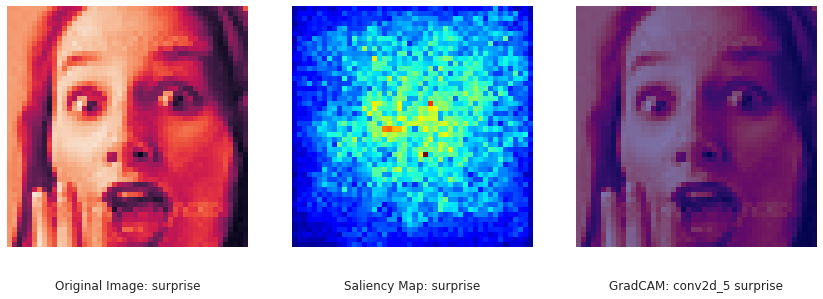

In [ ]:
plot_generation(model,label_cor_p,-14,True)

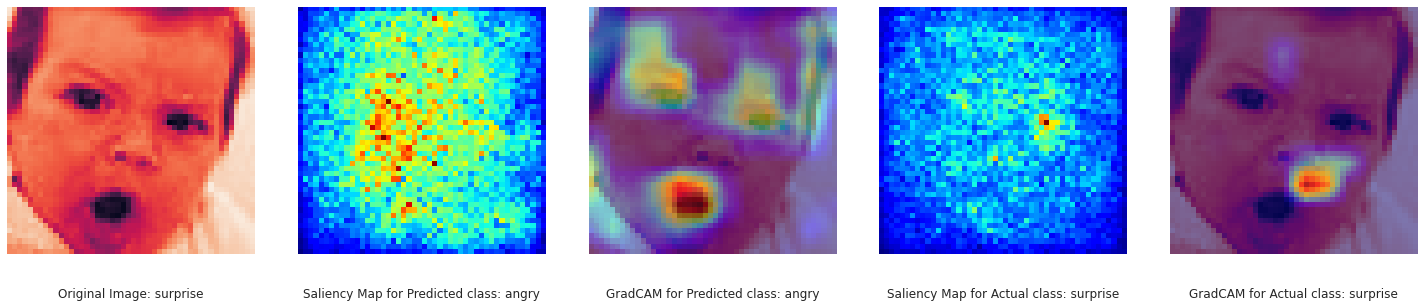

In [ ]:
plot_generation(model,label_incor_p,-14,False)

# focal loss

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 30.8 MB/s 


In [ ]:
import tensorflow_addons as tfa

model = tf.keras.models.Sequential()   
input_size = (48,48,1)
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
model.add(BatchNormalization())
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(classes, activation='softmax'))

#Compliling the model
fer_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9,nesterov=True)
adam_opt = tf.keras.optimizers.Adam(learning_rate=0.001)
scheduler = ReduceLROnPlateau(mode='max', factor=0.75, patience=5, verbose=True)
model.compile(optimizer=fer_optimizer,loss=tfa.losses.SigmoidFocalCrossEntropy(alpha=1.0),metrics=['accuracy'])


In [ ]:
hist_focal = model.fit(x=training_set,validation_data=test_set,epochs=60,callbacks=[scheduler])

Epoch 1/60
449/449 [==============================] - 27s 58ms/step - loss: 11.5315 - accuracy: 0.2511 - val_loss: 11.6083 - val_accuracy: 0.2471 - lr: 0.0100
Epoch 2/60
449/449 [==============================] - 26s 58ms/step - loss: 11.5486 - accuracy: 0.2513 - val_loss: 11.6083 - val_accuracy: 0.2471 - lr: 0.0100
Epoch 3/60
449/449 [==============================] - 26s 57ms/step - loss: 11.5484 - accuracy: 0.2513 - val_loss: 11.6083 - val_accuracy: 0.2471 - lr: 0.0100
Epoch 4/60
449/449 [==============================] - 27s 60ms/step - loss: 11.5486 - accuracy: 0.2513 - val_loss: 11.6083 - val_accuracy: 0.2471 - lr: 0.0100
Epoch 5/60
449/449 [==============================] - 26s 58ms/step - loss: 11.5484 - accuracy: 0.2513 - val_loss: 11.6083 - val_accuracy: 0.2471 - lr: 0.0100
Epoch 6/60
449/449 [==============================] - ETA: 0s - loss: 11.5488 - accuracy: 0.2513
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.007499999832361937.
449/449 [========================

KeyboardInterrupt: ignored

# Transfer Learning with Resnet50

In [ ]:
# define the model

base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3),include_top=False,weights="imagenet")

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
# Freezing Layers
# the flatten layer and the last three CNN layers are trainable
for layer in base_model.layers[:-4]:
    layer.trainable=False

In [ ]:
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(4096,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 batch_normalization (BatchN  (None, 8192)             32768     
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 4096)              33558528  
                                                                 
 batch_normalization_1 (Batc  (None, 4096)             16384     
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 4096)              0

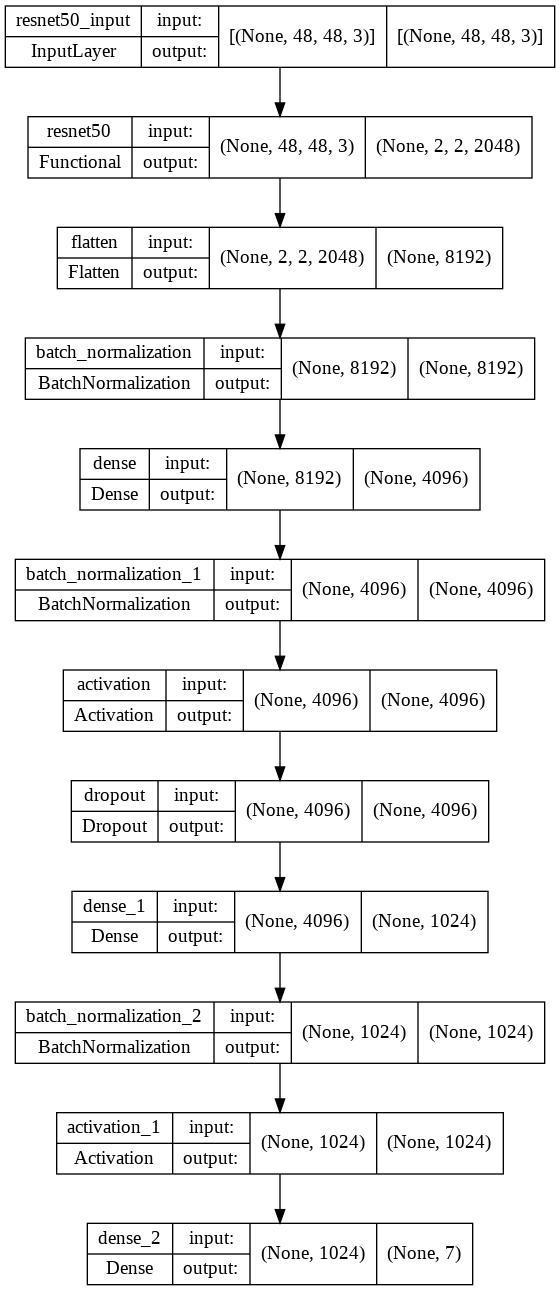

In [ ]:
# take a look at the model architechture
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [ ]:
# compile the model
METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=METRICS)

In [ ]:
# fit the model
CALLBACK = [
        ReduceLROnPlateau(mode='max', factor=0.5, patience=20, verbose=True),
        EarlyStopping(verbose=1, patience=20)
]
hist = model.fit(x=training_set_rgb,validation_data=test_set_rgb,epochs=70,callbacks=CALLBACK)

Epoch 1/70
449/449 [==============================] - 36s 79ms/step - loss: 1.3614 - accuracy: 0.4765 - precision: 0.7040 - recall: 0.2330 - auc: 0.8376 - val_loss: 1.4291 - val_accuracy: 0.4602 - val_precision: 0.6698 - val_recall: 0.2448 - val_auc: 0.8215 - lr: 6.2500e-05
Epoch 2/70
449/449 [==============================] - 35s 79ms/step - loss: 1.3587 - accuracy: 0.4787 - precision: 0.7140 - recall: 0.2369 - auc: 0.8382 - val_loss: 1.4257 - val_accuracy: 0.4611 - val_precision: 0.6654 - val_recall: 0.2474 - val_auc: 0.8230 - lr: 6.2500e-05
Epoch 3/70
449/449 [==============================] - 37s 82ms/step - loss: 1.3634 - accuracy: 0.4769 - precision: 0.6990 - recall: 0.2351 - auc: 0.8365 - val_loss: 1.4326 - val_accuracy: 0.4565 - val_precision: 0.6576 - val_recall: 0.2459 - val_auc: 0.8209 - lr: 6.2500e-05
Epoch 4/70
449/449 [==============================] - 38s 85ms/step - loss: 1.3664 - accuracy: 0.4741 - precision: 0.6981 - recall: 0.2339 - auc: 0.8360 - val_loss: 1.4290 - v

In [ ]:
model.evaluate(test_set_rgb)

113/113 [==============================] - 3s 29ms/step - loss: 1.4160 - accuracy: 0.4682 - precision: 0.6663 - recall: 0.2632 - auc: 0.8273


[1.4160490036010742,
 0.4682362675666809,
 0.6663139462471008,
 0.2631652355194092,
 0.8273231983184814]

Text(0.5, 0.98, 'Resnet w/ pretrain')

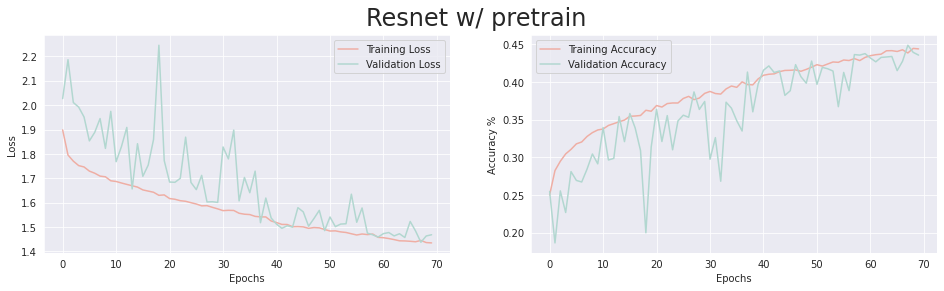

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0].plot(hist.history['loss'], color='#EFAEA4', label='Training Loss')
ax[0].plot(hist.history['val_loss'],
           color='#B2D7D0', label='Validation Loss')
ax[1].plot(hist.history['accuracy'],
           color='#EFAEA4', label='Training Accuracy')
ax[1].plot(hist.history['val_accuracy'],
           color='#B2D7D0', label='Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %')
fig.suptitle('Resnet w/ pretrain', fontsize=24)

# Transfer Learning with Resnet18

In [ ]:
import  tensorflow as tf
from    tensorflow import keras
from    tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D

class CellBlock(layers.Layer):
    def __init__(self, filter_num, stride=1):
        super(CellBlock, self).__init__()

        self.conv1 = Conv2D(filter_num, (3,3), strides=stride, padding='same')
        self.bn1 = BatchNormalization()
        self.relu = Activation('relu')

        self.conv2 = Conv2D(filter_num, (3,3), strides=1, padding='same')
        self.bn2 = BatchNormalization()

        if stride !=1:
            self.residual = Conv2D(filter_num, (1,1), strides=stride)
        else:
            self.residual = lambda x:x
        
    def call (self, inputs, training=None):

        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        r = self.residual(inputs)

        x = layers.add([x, r])
        output = tf.nn.relu(x)

        return output

class ResNet(models.Model):
    def __init__(self, layers_dims, nb_classes):
        super(ResNet, self).__init__()

        self.stem = Sequential([
            Conv2D(64, (7,7), strides=(2,2),padding='same'),
            BatchNormalization(),
            Activation('relu'),
            MaxPooling2D((3,3), strides=(2,2), padding='same')
        ]) 

        self.layer1 = self.build_cellblock(64, layers_dims[0]) 
        self.layer2 = self.build_cellblock(128, layers_dims[1], stride=2)
        self.layer3 = self.build_cellblock(256, layers_dims[2], stride=2)
        self.layer4 = self.build_cellblock(512, layers_dims[3], stride=2)

        self.avgpool = GlobalAveragePooling2D()
        self.fc = Dense(nb_classes, activation='softmax')
    
    def call(self, inputs, training=None):
        x=self.stem(inputs)

        x=self.layer1(x)
        x=self.layer2(x)
        x=self.layer3(x)
        x=self.layer4(x)
        
        x=self.avgpool(x)
        x=self.fc(x)

        return x

    def build_cellblock(self, filter_num, blocks, stride=1):
        res_blocks = Sequential()
        res_blocks.add(CellBlock(filter_num, stride))

        for _ in range(1, blocks):     
            res_blocks.add(CellBlock(filter_num, stride=1))

        return res_blocks


def build_ResNet(NetName, nb_classes):
    ResNet_Config = {'ResNet18':[2,2,2,2],'ResNet34':[3,4,6,3]}

    return ResNet(ResNet_Config[NetName], nb_classes) 


In [ ]:
model = build_ResNet('ResNet18', 7)
model.build(input_shape=(None, 48, 48, 1))

#Compliling the model
lrd = ReduceLROnPlateau(monitor='val_loss',patience=5,verbose=1,factor=0.75,min_lr=1e-8)
es = EarlyStopping(verbose=1, patience=20)
ms = ModelCheckpoint(filepath='resnet18',monitor='val_accuracy',save_best_only=True,mode='max')
optimizer_sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, decay=0.0001, nesterov=True)
model.compile(optimizer=optimizer_sgd, loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 12, 12, 64)        3456      
                                                                 
 sequential_1 (Sequential)   (None, 12, 12, 64)        148736    
                                                                 
 sequential_2 (Sequential)   (None, 6, 6, 128)         526976    
                                                                 
 sequential_3 (Sequential)   (None, 3, 3, 256)         2102528   
                                                                 
 sequential_4 (Sequential)   (None, 2, 2, 512)         8399360   
                                                                 
 global_average_pooling2d (G  multiple                 0         
 lobalAveragePooling2D)                                          
                                                           

In [ ]:
hist = model.fit(x=training_set,validation_data=test_set,epochs=60,callbacks=[lrd,es,ms])

Epoch 1/60
225/225 [==============================] - ETA: 0s - loss: 1.7329 - accuracy: 0.3150

INFO:tensorflow:Assets written to: resnet18/assets


INFO:tensorflow:Assets written to: resnet18/assets


225/225 [==============================] - 52s 173ms/step - loss: 1.7329 - accuracy: 0.3150 - val_loss: 1.7899 - val_accuracy: 0.3097 - lr: 0.0100
Epoch 2/60
225/225 [==============================] - ETA: 0s - loss: 1.5354 - accuracy: 0.3979

INFO:tensorflow:Assets written to: resnet18/assets


INFO:tensorflow:Assets written to: resnet18/assets


225/225 [==============================] - 37s 165ms/step - loss: 1.5354 - accuracy: 0.3979 - val_loss: 1.5775 - val_accuracy: 0.3759 - lr: 0.0100
Epoch 3/60
225/225 [==============================] - ETA: 0s - loss: 1.4326 - accuracy: 0.4467

INFO:tensorflow:Assets written to: resnet18/assets


INFO:tensorflow:Assets written to: resnet18/assets


225/225 [==============================] - 37s 164ms/step - loss: 1.4326 - accuracy: 0.4467 - val_loss: 1.5032 - val_accuracy: 0.4248 - lr: 0.0100
Epoch 4/60
225/225 [==============================] - 26s 116ms/step - loss: 1.3572 - accuracy: 0.4808 - val_loss: 1.4673 - val_accuracy: 0.3994 - lr: 0.0100
Epoch 5/60
225/225 [==============================] - 27s 119ms/step - loss: 1.2971 - accuracy: 0.5032 - val_loss: 1.4747 - val_accuracy: 0.4192 - lr: 0.0100
Epoch 6/60
225/225 [==============================] - ETA: 0s - loss: 1.2615 - accuracy: 0.5184

INFO:tensorflow:Assets written to: resnet18/assets


INFO:tensorflow:Assets written to: resnet18/assets


225/225 [==============================] - 37s 164ms/step - loss: 1.2615 - accuracy: 0.5184 - val_loss: 1.2596 - val_accuracy: 0.5164 - lr: 0.0100
Epoch 7/60
225/225 [==============================] - 26s 115ms/step - loss: 1.2223 - accuracy: 0.5353 - val_loss: 1.4396 - val_accuracy: 0.4262 - lr: 0.0100
Epoch 8/60
225/225 [==============================] - 26s 115ms/step - loss: 1.1893 - accuracy: 0.5456 - val_loss: 1.3907 - val_accuracy: 0.4948 - lr: 0.0100
Epoch 9/60
225/225 [==============================] - ETA: 0s - loss: 1.1677 - accuracy: 0.5547

INFO:tensorflow:Assets written to: resnet18/assets


INFO:tensorflow:Assets written to: resnet18/assets


225/225 [==============================] - 37s 164ms/step - loss: 1.1677 - accuracy: 0.5547 - val_loss: 1.1689 - val_accuracy: 0.5531 - lr: 0.0100
Epoch 10/60
225/225 [==============================] - 26s 116ms/step - loss: 1.1393 - accuracy: 0.5681 - val_loss: 1.2170 - val_accuracy: 0.5439 - lr: 0.0100
Epoch 11/60
225/225 [==============================] - 26s 115ms/step - loss: 1.1253 - accuracy: 0.5688 - val_loss: 1.1881 - val_accuracy: 0.5524 - lr: 0.0100
Epoch 12/60
225/225 [==============================] - 26s 115ms/step - loss: 1.1043 - accuracy: 0.5804 - val_loss: 1.1919 - val_accuracy: 0.5404 - lr: 0.0100
Epoch 13/60
225/225 [==============================] - 26s 115ms/step - loss: 1.0787 - accuracy: 0.5915 - val_loss: 1.2389 - val_accuracy: 0.5223 - lr: 0.0100
Epoch 14/60
225/225 [==============================] - ETA: 0s - loss: 1.0694 - accuracy: 0.5947
Epoch 14: ReduceLROnPlateau reducing learning rate to 0.007499999832361937.


INFO:tensorflow:Assets written to: resnet18/assets


INFO:tensorflow:Assets written to: resnet18/assets


225/225 [==============================] - 37s 164ms/step - loss: 1.0694 - accuracy: 0.5947 - val_loss: 1.1789 - val_accuracy: 0.5582 - lr: 0.0100
Epoch 15/60
225/225 [==============================] - ETA: 0s - loss: 1.0376 - accuracy: 0.6072

INFO:tensorflow:Assets written to: resnet18/assets


INFO:tensorflow:Assets written to: resnet18/assets


225/225 [==============================] - 37s 164ms/step - loss: 1.0376 - accuracy: 0.6072 - val_loss: 1.1185 - val_accuracy: 0.5894 - lr: 0.0075
Epoch 16/60
225/225 [==============================] - 26s 114ms/step - loss: 1.0117 - accuracy: 0.6186 - val_loss: 1.1122 - val_accuracy: 0.5825 - lr: 0.0075
Epoch 17/60
225/225 [==============================] - 26s 114ms/step - loss: 1.0047 - accuracy: 0.6195 - val_loss: 1.3660 - val_accuracy: 0.4919 - lr: 0.0075
Epoch 18/60
225/225 [==============================] - 26s 117ms/step - loss: 0.9935 - accuracy: 0.6264 - val_loss: 1.1048 - val_accuracy: 0.5883 - lr: 0.0075
Epoch 19/60
225/225 [==============================] - 26s 113ms/step - loss: 0.9704 - accuracy: 0.6382 - val_loss: 1.1150 - val_accuracy: 0.5836 - lr: 0.0075
Epoch 20/60
225/225 [==============================] - 26s 114ms/step - loss: 0.9681 - accuracy: 0.6345 - val_loss: 1.1250 - val_accuracy: 0.5893 - lr: 0.0075
Epoch 21/60
225/225 [==============================] - 26s

INFO:tensorflow:Assets written to: resnet18/assets


INFO:tensorflow:Assets written to: resnet18/assets


225/225 [==============================] - 37s 163ms/step - loss: 0.9292 - accuracy: 0.6509 - val_loss: 1.1141 - val_accuracy: 0.5975 - lr: 0.0075
Epoch 24/60
225/225 [==============================] - 26s 115ms/step - loss: 0.8992 - accuracy: 0.6638 - val_loss: 1.1552 - val_accuracy: 0.5887 - lr: 0.0056
Epoch 25/60
225/225 [==============================] - 26s 115ms/step - loss: 0.8876 - accuracy: 0.6683 - val_loss: 1.1101 - val_accuracy: 0.5894 - lr: 0.0056
Epoch 26/60
225/225 [==============================] - 26s 115ms/step - loss: 0.8799 - accuracy: 0.6718 - val_loss: 1.1264 - val_accuracy: 0.5878 - lr: 0.0056
Epoch 27/60
225/225 [==============================] - ETA: 0s - loss: 0.8679 - accuracy: 0.6739

INFO:tensorflow:Assets written to: resnet18/assets


INFO:tensorflow:Assets written to: resnet18/assets


225/225 [==============================] - 36s 162ms/step - loss: 0.8679 - accuracy: 0.6739 - val_loss: 1.0778 - val_accuracy: 0.6096 - lr: 0.0056
Epoch 28/60
225/225 [==============================] - ETA: 0s - loss: 0.8590 - accuracy: 0.6781

INFO:tensorflow:Assets written to: resnet18/assets


INFO:tensorflow:Assets written to: resnet18/assets


225/225 [==============================] - 37s 163ms/step - loss: 0.8590 - accuracy: 0.6781 - val_loss: 1.0623 - val_accuracy: 0.6135 - lr: 0.0056
Epoch 29/60
225/225 [==============================] - 27s 118ms/step - loss: 0.8517 - accuracy: 0.6802 - val_loss: 1.0969 - val_accuracy: 0.6070 - lr: 0.0056
Epoch 30/60
225/225 [==============================] - ETA: 0s - loss: 0.8383 - accuracy: 0.6843

INFO:tensorflow:Assets written to: resnet18/assets


INFO:tensorflow:Assets written to: resnet18/assets


225/225 [==============================] - 36s 162ms/step - loss: 0.8383 - accuracy: 0.6843 - val_loss: 1.0516 - val_accuracy: 0.6202 - lr: 0.0056
Epoch 31/60
225/225 [==============================] - 26s 114ms/step - loss: 0.8290 - accuracy: 0.6889 - val_loss: 1.0719 - val_accuracy: 0.6166 - lr: 0.0056
Epoch 32/60
225/225 [==============================] - 26s 114ms/step - loss: 0.8196 - accuracy: 0.6905 - val_loss: 1.0790 - val_accuracy: 0.6202 - lr: 0.0056
Epoch 33/60
225/225 [==============================] - 26s 114ms/step - loss: 0.8093 - accuracy: 0.6980 - val_loss: 1.0911 - val_accuracy: 0.6167 - lr: 0.0056
Epoch 34/60
225/225 [==============================] - 26s 115ms/step - loss: 0.7954 - accuracy: 0.7016 - val_loss: 1.1243 - val_accuracy: 0.6013 - lr: 0.0056
Epoch 35/60
225/225 [==============================] - ETA: 0s - loss: 0.7826 - accuracy: 0.7073
Epoch 35: ReduceLROnPlateau reducing learning rate to 0.004218749818392098.
225/225 [==============================] - 2

INFO:tensorflow:Assets written to: resnet18/assets


INFO:tensorflow:Assets written to: resnet18/assets


225/225 [==============================] - 37s 163ms/step - loss: 0.7624 - accuracy: 0.7172 - val_loss: 1.0733 - val_accuracy: 0.6257 - lr: 0.0042
Epoch 37/60
225/225 [==============================] - ETA: 0s - loss: 0.7414 - accuracy: 0.7234

INFO:tensorflow:Assets written to: resnet18/assets


INFO:tensorflow:Assets written to: resnet18/assets


225/225 [==============================] - 37s 164ms/step - loss: 0.7414 - accuracy: 0.7234 - val_loss: 1.0796 - val_accuracy: 0.6262 - lr: 0.0042
Epoch 38/60
225/225 [==============================] - 26s 115ms/step - loss: 0.7328 - accuracy: 0.7263 - val_loss: 1.2220 - val_accuracy: 0.5797 - lr: 0.0042
Epoch 39/60
225/225 [==============================] - ETA: 0s - loss: 0.7303 - accuracy: 0.7258

INFO:tensorflow:Assets written to: resnet18/assets


INFO:tensorflow:Assets written to: resnet18/assets


225/225 [==============================] - 38s 168ms/step - loss: 0.7303 - accuracy: 0.7258 - val_loss: 1.0782 - val_accuracy: 0.6300 - lr: 0.0042
Epoch 40/60
225/225 [==============================] - ETA: 0s - loss: 0.7138 - accuracy: 0.7337
Epoch 40: ReduceLROnPlateau reducing learning rate to 0.003164062276482582.
225/225 [==============================] - 26s 115ms/step - loss: 0.7138 - accuracy: 0.7337 - val_loss: 1.0997 - val_accuracy: 0.6280 - lr: 0.0042
Epoch 41/60
225/225 [==============================] - 26s 116ms/step - loss: 0.6899 - accuracy: 0.7415 - val_loss: 1.1666 - val_accuracy: 0.6163 - lr: 0.0032
Epoch 42/60
225/225 [==============================] - ETA: 0s - loss: 0.6704 - accuracy: 0.7515

INFO:tensorflow:Assets written to: resnet18/assets


INFO:tensorflow:Assets written to: resnet18/assets


225/225 [==============================] - 37s 167ms/step - loss: 0.6704 - accuracy: 0.7515 - val_loss: 1.1136 - val_accuracy: 0.6310 - lr: 0.0032
Epoch 43/60
225/225 [==============================] - ETA: 0s - loss: 0.6639 - accuracy: 0.7521

INFO:tensorflow:Assets written to: resnet18/assets


INFO:tensorflow:Assets written to: resnet18/assets


225/225 [==============================] - 37s 164ms/step - loss: 0.6639 - accuracy: 0.7521 - val_loss: 1.1180 - val_accuracy: 0.6318 - lr: 0.0032
Epoch 44/60
225/225 [==============================] - 26s 115ms/step - loss: 0.6566 - accuracy: 0.7587 - val_loss: 1.1576 - val_accuracy: 0.6317 - lr: 0.0032
Epoch 45/60
225/225 [==============================] - ETA: 0s - loss: 0.6443 - accuracy: 0.7610
Epoch 45: ReduceLROnPlateau reducing learning rate to 0.0023730467073619366.
225/225 [==============================] - 26s 115ms/step - loss: 0.6443 - accuracy: 0.7610 - val_loss: 1.1881 - val_accuracy: 0.6109 - lr: 0.0032
Epoch 46/60
225/225 [==============================] - 26s 114ms/step - loss: 0.6201 - accuracy: 0.7716 - val_loss: 1.3200 - val_accuracy: 0.5800 - lr: 0.0024
Epoch 47/60
225/225 [==============================] - ETA: 0s - loss: 0.6129 - accuracy: 0.7737

INFO:tensorflow:Assets written to: resnet18/assets


INFO:tensorflow:Assets written to: resnet18/assets


225/225 [==============================] - 37s 163ms/step - loss: 0.6129 - accuracy: 0.7737 - val_loss: 1.1494 - val_accuracy: 0.6364 - lr: 0.0024
Epoch 48/60
225/225 [==============================] - 26s 115ms/step - loss: 0.5965 - accuracy: 0.7808 - val_loss: 1.1640 - val_accuracy: 0.6294 - lr: 0.0024
Epoch 49/60
225/225 [==============================] - 26s 114ms/step - loss: 0.5872 - accuracy: 0.7847 - val_loss: 1.2147 - val_accuracy: 0.6261 - lr: 0.0024
Epoch 50/60
225/225 [==============================] - ETA: 0s - loss: 0.5809 - accuracy: 0.7877
Epoch 50: ReduceLROnPlateau reducing learning rate to 0.0017797850305214524.
225/225 [==============================] - 27s 119ms/step - loss: 0.5809 - accuracy: 0.7877 - val_loss: 1.2018 - val_accuracy: 0.6247 - lr: 0.0024
Epoch 50: early stopping


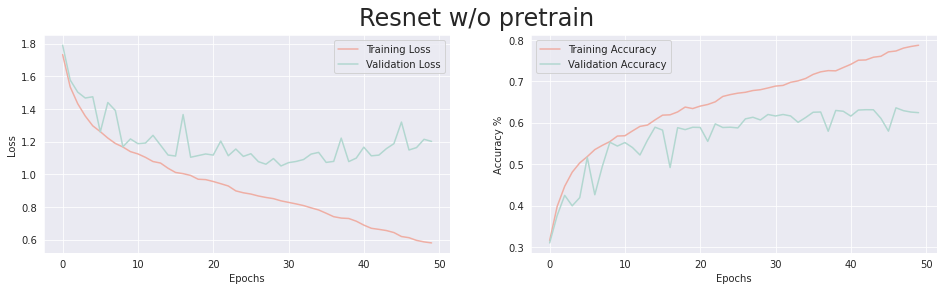

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0].plot(hist.history['loss'], color='#EFAEA4', label='Training Loss')
ax[0].plot(hist.history['val_loss'],
           color='#B2D7D0', label='Validation Loss')
ax[1].plot(hist.history['accuracy'],
           color='#EFAEA4', label='Training Accuracy')
ax[1].plot(hist.history['val_accuracy'],
           color='#B2D7D0', label='Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %')
fig.suptitle('Resnet w/o pretrain', fontsize=24)
plt.savefig("filename.png")

In [ ]:
# Take a look at the images, predicted labels, and true labels
y_prob = model.predict(test_set)
y_pred = np.argmax(y_prob, axis = 1)
y_true = test_set.labels
class_labels = list(test_set.class_indices.keys())

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true,y_pred)

0.6246865422123155

In [ ]:
# Generate a report based on the results of claasification on different classes
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

       angry       0.47      0.62      0.54       958
     disgust       0.76      0.51      0.61       111
        fear       0.48      0.46      0.47      1024
       happy       0.87      0.79      0.83      1774
     neutral       0.58      0.60      0.59      1233
         sad       0.53      0.44      0.48      1247
    surprise       0.71      0.79      0.75       831

    accuracy                           0.62      7178
   macro avg       0.63      0.60      0.61      7178
weighted avg       0.63      0.62      0.63      7178



Text(159.0, 0.5, 'Truth')

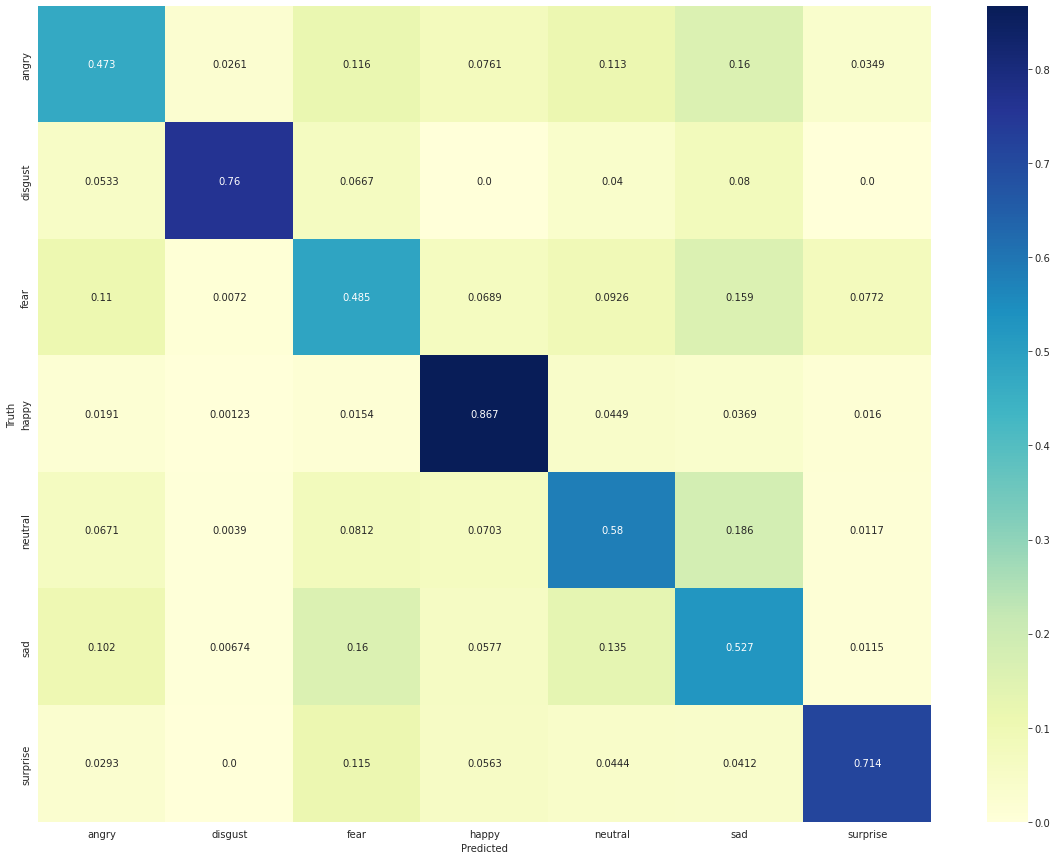

In [ ]:
#Plot the confusion metrics to take a look at the performance of the model on different classes
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_pred, y_true)
# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize = (20, 15))
sns.heatmap(cmn, annot = True, fmt = '.3', xticklabels = class_labels,
            yticklabels = class_labels,cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Transfer Learning with VGG16

### Without pretrain

In [ ]:
# define the model

base_model_vgg = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights=None)

In [ ]:
# Building Model

model = tf.keras.models.Sequential()
model.add(base_model_vgg)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout_3 (Dropout)         (None, 1, 1, 512)         0         
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 32)                16416     
                                                                 
 batch_normalization_4 (Batc  (None, 32)               128       
 hNormalization)                                      

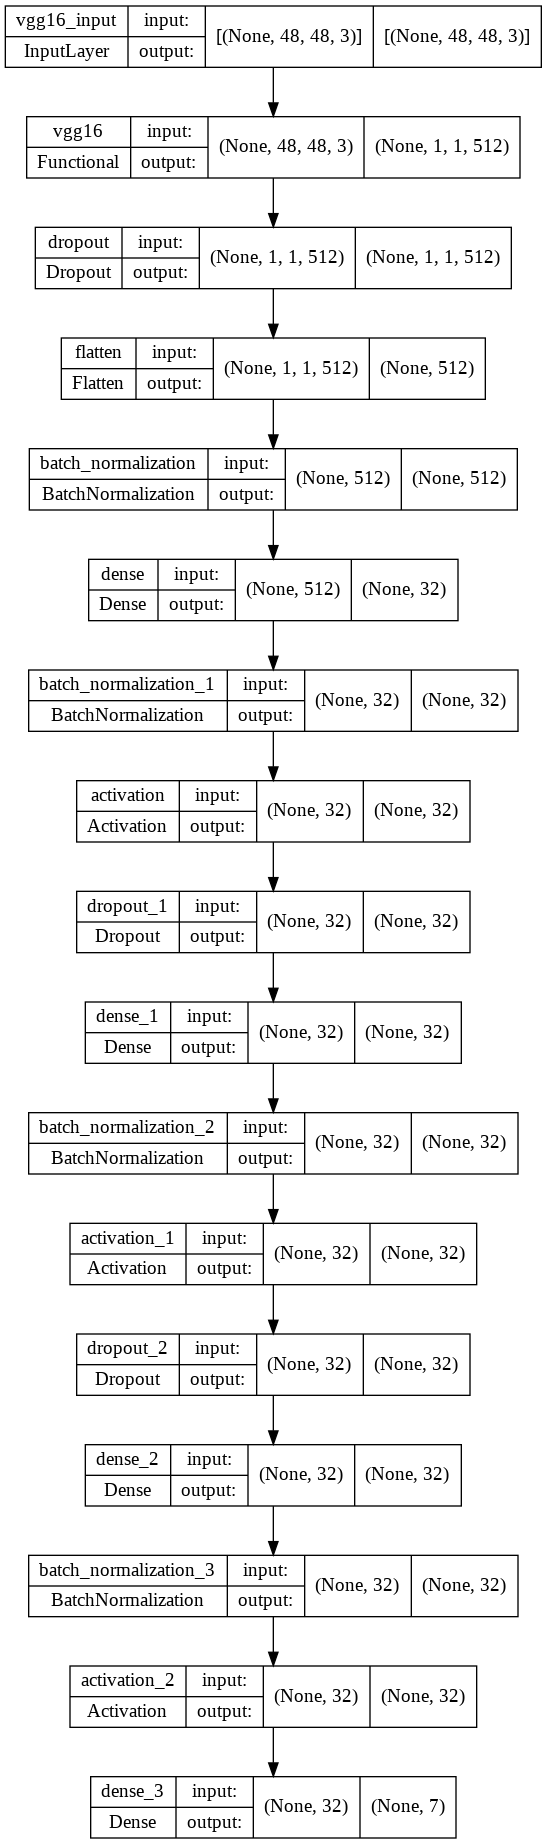

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [ ]:
# compile the model
METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=METRICS)

In [ ]:
# fit the model
CALLBACK = [
        ReduceLROnPlateau(mode='max', factor=0.5, patience=20, verbose=True),
        EarlyStopping(verbose=1, patience=20, restore_best_weights=True)
]
hist = model.fit(x=training_set_rgb,validation_data=test_set_rgb,epochs=100,callbacks=CALLBACK)

Epoch 1/100
449/449 [==============================] - 42s 89ms/step - loss: 1.8953 - accuracy: 0.2229 - precision: 0.1858 - recall: 0.0053 - auc: 0.6162 - val_loss: 1.8224 - val_accuracy: 0.2471 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6420 - lr: 0.0010
Epoch 2/100
449/449 [==============================] - 38s 85ms/step - loss: 1.8193 - accuracy: 0.2471 - precision: 0.2034 - recall: 4.1799e-04 - auc: 0.6436 - val_loss: 1.8549 - val_accuracy: 0.1712 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6087 - lr: 0.0010
Epoch 3/100
449/449 [==============================] - 39s 86ms/step - loss: 1.8119 - accuracy: 0.2497 - precision: 0.2273 - recall: 1.7416e-04 - auc: 0.6468 - val_loss: 1.7996 - val_accuracy: 0.2555 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6601 - lr: 0.0010
Epoch 4/100
449/449 [==============================] - 38s 84ms/step - loss: 1.8021 - accuracy: 0.2524 - precision: 0.5000 - recall: 6.9665e-05 - auc: 0

Text(0.5, 0.98, 'VGG16 w/o pretrain')

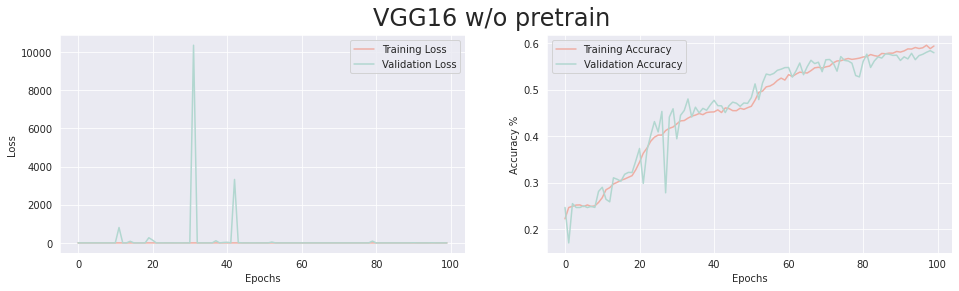

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0].plot(hist.history['loss'], color='#EFAEA4', label='Training Loss')
ax[0].plot(hist.history['val_loss'],
           color='#B2D7D0', label='Validation Loss')
ax[1].plot(hist.history['accuracy'],
           color='#EFAEA4', label='Training Accuracy')
ax[1].plot(hist.history['val_accuracy'],
           color='#B2D7D0', label='Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %')
fig.suptitle('VGG16 w/o pretrain', fontsize=24)

In [ ]:
model.evaluate(test_set_rgb)

113/113 [==============================] - 3s 24ms/step - loss: 1.1587 - accuracy: 0.5789 - precision: 0.8522 - recall: 0.3341 - auc: 0.8871


[1.1586545705795288,
 0.5788520574569702,
 0.8521677255630493,
 0.3340763449668884,
 0.887067437171936]

In [ ]:
# Take a look at the images, predicted labels, and true labels
y_prob = model.predict(test_set_rgb)
y_pred = np.argmax(y_prob, axis = 1)
y_true = test_set.labels
class_labels = list(test_set.class_indices.keys())

In [ ]:
# Generate a report based on the results of claasification on different classes
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

       angry       0.36      0.62      0.45       958
     disgust       0.00      0.00      0.00       111
        fear       0.36      0.09      0.15      1024
       happy       0.88      0.85      0.86      1774
     neutral       0.66      0.51      0.57      1233
         sad       0.40      0.58      0.47      1247
    surprise       0.77      0.74      0.76       831

    accuracy                           0.58      7178
   macro avg       0.49      0.48      0.47      7178
weighted avg       0.59      0.58      0.56      7178



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(159.0, 0.5, 'Truth')

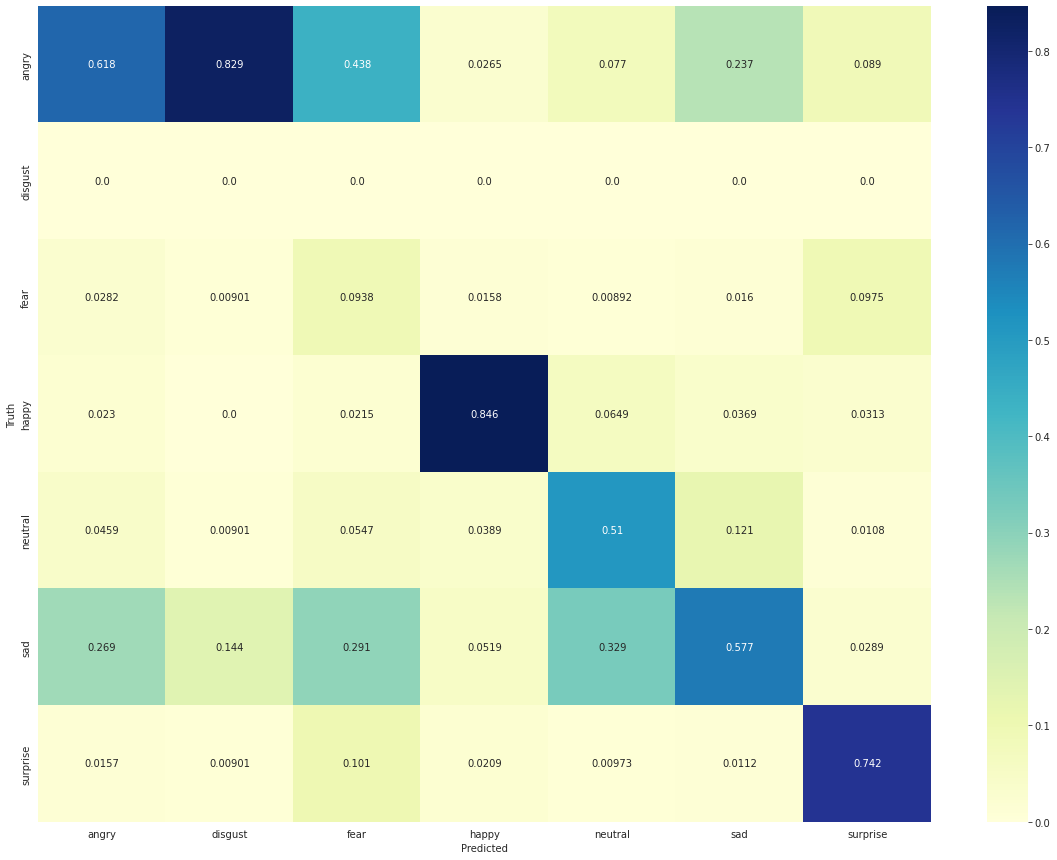

In [ ]:
#Plot the confusion metrics to take a look at the performance of the model on different classes
import seaborn as sns
from sklearn.metrics import confusion_matrix

cmn = confusion_matrix(y_pred, y_true, normalize='pred')


plt.figure(figsize = (20, 15))
sns.heatmap(cmn, annot = True, fmt = '.3', xticklabels = class_labels,
            yticklabels = class_labels,cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('Truth')

### With pretrain (weights from Imagenet)

In [ ]:
# define the model

base_model_vgg1 = tf.keras.applications.VGG16(input_shape=(48,48,3),include_top=False,weights="imagenet")

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
for layer in base_model_vgg1.layers[:-4]:
  layer.trainable == False

In [ ]:
# Building Model

model_16 = tf.keras.models.Sequential()
model_16.add(base_model_vgg1)
model_16.add(Flatten())
model_16.add(Dropout(0.5))
model_16.add(Dense(4096, activation='relu'))
model_16.add(Dropout(0.5))
model_16.add(Dense(1024, activation='relu'))
model_16.add(Dense(7,activation='softmax'))
model_16.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 4096)              2101248   
                                                                 
 dropout_7 (Dropout)         (None, 4096)              0         
                                                                 
 dense_8 (Dense)             (None, 1024)              4195328   
                                                                 
 dense_9 (Dense)             (None, 7)                

In [ ]:
# compile the model
METRICS = [
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]


model_16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=METRICS)

In [ ]:
# fit the model
CALLBACK = [
        ReduceLROnPlateau(mode='max', factor=0.5, patience=20, verbose=True),
        EarlyStopping(verbose=1, patience=30, restore_best_weights=True)
]
hist = model_16.fit(x=training_set_rgb,validation_data=test_set_rgb,epochs=160,callbacks=CALLBACK)

Epoch 1/160
449/449 [==============================] - 46s 103ms/step - loss: 0.6815 - accuracy: 0.7509 - precision: 0.8191 - recall: 0.6809 - auc: 0.9605 - val_loss: 0.9737 - val_accuracy: 0.6580 - val_precision: 0.7302 - val_recall: 0.5901 - val_auc: 0.9249 - lr: 5.0000e-04
Epoch 2/160
449/449 [==============================] - 46s 103ms/step - loss: 0.6765 - accuracy: 0.7534 - precision: 0.8202 - recall: 0.6846 - auc: 0.9609 - val_loss: 0.9619 - val_accuracy: 0.6612 - val_precision: 0.7380 - val_recall: 0.5917 - val_auc: 0.9256 - lr: 5.0000e-04
Epoch 3/160
449/449 [==============================] - 46s 102ms/step - loss: 0.6735 - accuracy: 0.7561 - precision: 0.8230 - recall: 0.6887 - auc: 0.9613 - val_loss: 0.9620 - val_accuracy: 0.6701 - val_precision: 0.7256 - val_recall: 0.6173 - val_auc: 0.9284 - lr: 5.0000e-04
Epoch 4/160
449/449 [==============================] - 47s 104ms/step - loss: 0.6663 - accuracy: 0.7582 - precision: 0.8213 - recall: 0.6930 - auc: 0.9620 - val_loss: 0.

In [ ]:
model_16.evaluate(test_set_rgb)

113/113 [==============================] - 4s 34ms/step - loss: 0.9511 - accuracy: 0.6722 - precision: 0.7303 - recall: 0.6152 - auc: 0.9292


[0.9511188268661499,
 0.6721928119659424,
 0.7302795052528381,
 0.61521315574646,
 0.929238498210907]

Text(0.5, 0.98, 'VGG16 with pretrain')

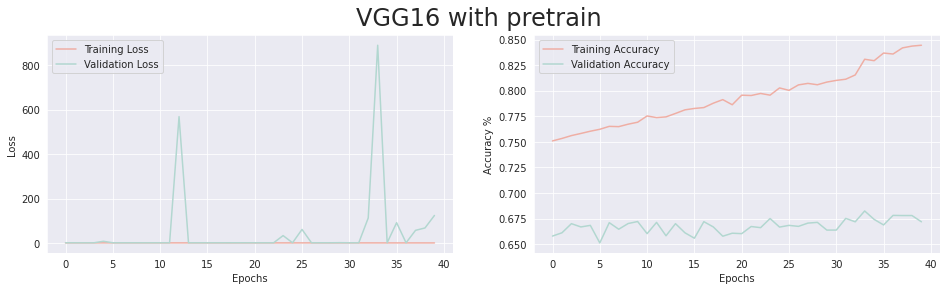

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0].plot(hist.history['loss'], color='#EFAEA4', label='Training Loss')
ax[0].plot(hist.history['val_loss'],
           color='#B2D7D0', label='Validation Loss')
ax[1].plot(hist.history['accuracy'],
           color='#EFAEA4', label='Training Accuracy')
ax[1].plot(hist.history['val_accuracy'],
           color='#B2D7D0', label='Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %')
fig.suptitle('VGG16 with pretrain(ImageNet)', fontsize=24)

In [ ]:
# Take a look at the images, predicted labels, and true labels
y_prob = model_16.predict(test_set_rgb)
y_pred = np.argmax(y_prob, axis = 1)
y_true = test_set.labels
class_labels = list(test_set.class_indices.keys())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


In [ ]:
# Generate a report based on the results of claasification on different classes
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

       angry       0.58      0.61      0.60       958
     disgust       0.79      0.40      0.53       111
        fear       0.52      0.51      0.51      1024
       happy       0.90      0.86      0.88      1774
     neutral       0.57      0.74      0.65      1233
         sad       0.59      0.49      0.54      1247
    surprise       0.81      0.75      0.78       831

    accuracy                           0.67      7178
   macro avg       0.68      0.62      0.64      7178
weighted avg       0.68      0.67      0.67      7178



Text(159.0, 0.5, 'Truth')

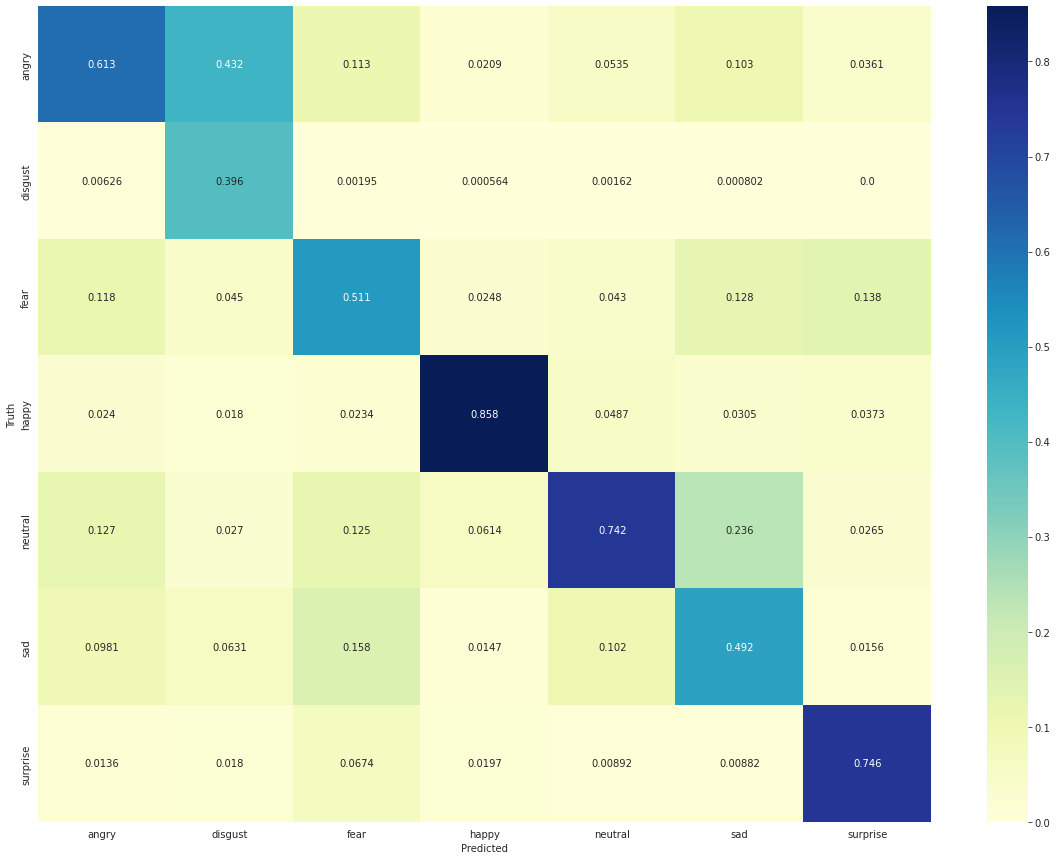

In [ ]:
#Plot the confusion metrics to take a look at the performance of the model on different classes
import seaborn as sns
from sklearn.metrics import confusion_matrix

cmn = confusion_matrix(y_pred, y_true, normalize='pred')


plt.figure(figsize = (20, 15))
sns.heatmap(cmn, annot = True, fmt = '.3', xticklabels = class_labels,
            yticklabels = class_labels,cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('Truth')

### With pretrain(weights from [vggface](https://github.com/rcmalli/keras-vggface/tree/719ad75625fe51436b9a9479114b3d136847e11a))




In [ ]:
training_set_224 = train_datagen.flow_from_directory(train_dir,batch_size=64,
                           target_size=(224,224),shuffle=True,
                           color_mode='rgb',
                           class_mode='categorical')

test_set_224 = test_datagen.flow_from_directory(test_dir,batch_size=64,
                        target_size=(224,224),
                        shuffle=False,
                        color_mode='rgb',
                        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
base_model_vgg = tf.keras.applications.VGG16(input_shape=(224,224,3),include_top=False,weights="vgg16.h5",pooling = 'avg')
end = base_model_vgg.get_layer('block5_pool').output
x = Flatten(name='flatten')(end)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu', name='fc6')(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu', name='fc7')(x)

In [ ]:
for i in range(19):
    base_model_vgg.layers[i].trainable = False

In [ ]:
out = Dense(7, activation='softmax', name='classifier')(x)
model_vgg = tf.keras.Model(base_model_vgg.input, out)

In [ ]:
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=METRICS)

In [ ]:
CALLBACK = [
        ReduceLROnPlateau(mode='max', factor=0.5, patience=20, verbose=True),
        EarlyStopping(verbose=1, patience=30, restore_best_weights=True)
]

In [ ]:
hist_face = model_vgg.fit(x=training_set_224,validation_data=test_set_224,epochs=60,callbacks=CALLBACK)

Epoch 1/60
449/449 [==============================] - 328s 702ms/step - loss: 1.4520 - accuracy: 0.4432 - precision: 0.6909 - recall: 0.2098 - auc: 0.8124 - val_loss: 1.1467 - val_accuracy: 0.5683 - val_precision: 0.7773 - val_recall: 0.3472 - val_auc: 0.8888 - lr: 0.0010
Epoch 2/60
449/449 [==============================] - 313s 698ms/step - loss: 1.3007 - accuracy: 0.5052 - precision: 0.7187 - recall: 0.2872 - auc: 0.8537 - val_loss: 1.1180 - val_accuracy: 0.5790 - val_precision: 0.7422 - val_recall: 0.3986 - val_auc: 0.8943 - lr: 0.0010
Epoch 3/60
449/449 [==============================] - 312s 694ms/step - loss: 1.2554 - accuracy: 0.5258 - precision: 0.7318 - recall: 0.3128 - auc: 0.8646 - val_loss: 1.1057 - val_accuracy: 0.5896 - val_precision: 0.7733 - val_recall: 0.3727 - val_auc: 0.8973 - lr: 0.0010
Epoch 4/60
449/449 [==============================] - 311s 692ms/step - loss: 1.2215 - accuracy: 0.5390 - precision: 0.7351 - recall: 0.3352 - auc: 0.8725 - val_loss: 1.0644 - val_a

In [ ]:
model_vgg.evaluate(test_set_224)

113/113 [==============================] - 18s 156ms/step - loss: 0.9142 - accuracy: 0.6765 - precision: 0.7734 - recall: 0.5734 - auc: 0.9306


[0.9142318367958069,
 0.6765115857124329,
 0.773393452167511,
 0.5734187960624695,
 0.9306049346923828]

In [ ]:
# Take a look at the images, predicted labels, and true labels
y_prob = model_vgg.predict(test_set_224)
y_pred = np.argmax(y_prob, axis = 1)
y_true = test_set.labels
class_labels = list(test_set.class_indices.keys())

In [ ]:
# Generate a report based on the results of claasification on different classes
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_labels))

              precision    recall  f1-score   support

       angry       0.63      0.62      0.63       958
     disgust       0.74      0.57      0.64       111
        fear       0.62      0.36      0.46      1024
       happy       0.83      0.88      0.85      1774
     neutral       0.59      0.71      0.65      1233
         sad       0.55      0.60      0.57      1247
    surprise       0.78      0.77      0.77       831

    accuracy                           0.68      7178
   macro avg       0.68      0.64      0.65      7178
weighted avg       0.68      0.68      0.67      7178



Text(159.0, 0.5, 'Truth')

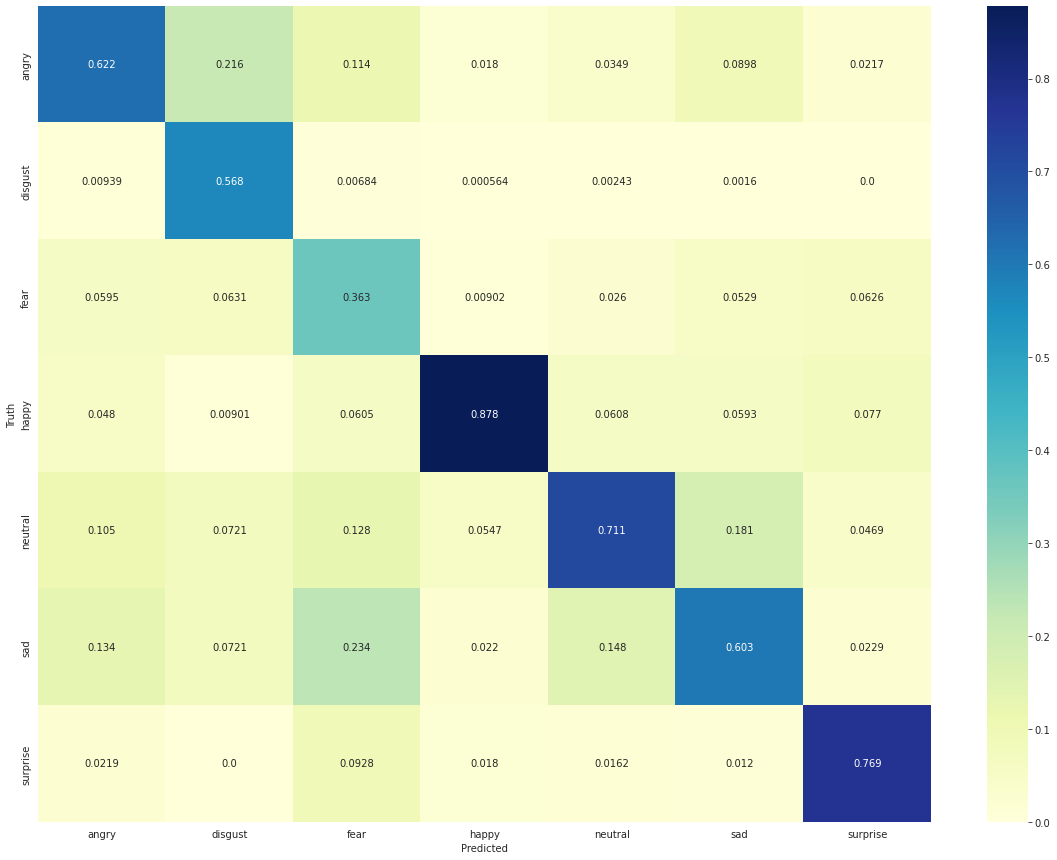

In [ ]:
#Plot the confusion metrics to take a look at the performance of the model on different classes
import seaborn as sns
from sklearn.metrics import confusion_matrix

cmn = confusion_matrix(y_pred, y_true, normalize='pred')


plt.figure(figsize = (20, 15))
sns.heatmap(cmn, annot = True, fmt = '.3', xticklabels = class_labels,
            yticklabels = class_labels,cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
model_vgg.save('vggface_best')

INFO:tensorflow:Assets written to: vggface_best/assets


Text(0.5, 0.98, 'VGG16 w/o pretrain( VGGface)')

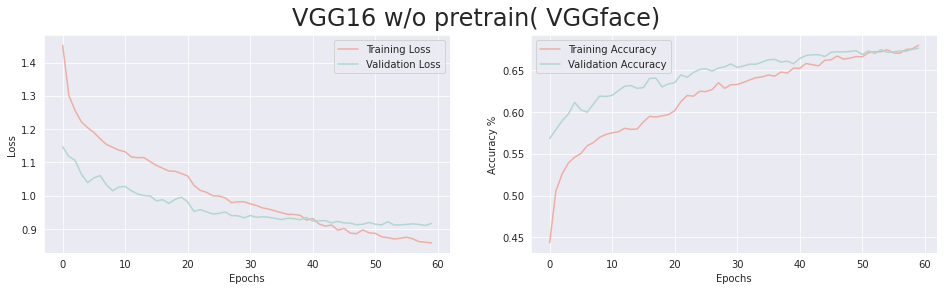

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0].plot(hist_face.history['loss'], color='#EFAEA4', label='Training Loss')
ax[0].plot(hist_face.history['val_loss'],
           color='#B2D7D0', label='Validation Loss')
ax[1].plot(hist_face.history['accuracy'],
           color='#EFAEA4', label='Training Accuracy')
ax[1].plot(hist_face.history['val_accuracy'],
           color='#B2D7D0', label='Validation Accuracy')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy %')
fig.suptitle('VGG16 with pretrain( VGGface)', fontsize=24)

# Transfer Learning with Inception-V3

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2,
    rotation_range=5,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    # fill_mode="nearest",
)

valid_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [ ]:
train_dataset = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(75, 75),
    class_mode="categorical",
    subset="training",
    batch_size=64,
)

Found 22968 images belonging to 7 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(75, 75),
    class_mode="categorical",
    subset="validation",
    batch_size=64,
)

Found 5741 images belonging to 7 classes.


In [ ]:
test_dataset = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(75, 75),
    class_mode="categorical",
    batch_size=64,
)

Found 7178 images belonging to 7 classes.


In [ ]:
base_model = InceptionV3(
    include_top=False,
    input_shape=(75, 75, 3),
    pooling=None,
)

In [ ]:
# # Freezing Layers

# for layer in base_model.layers[:-4]:
#     layer.trainable=False

In [ ]:
EPOCHS = 100
BS = 128
DROPOUT_RATE = 0.5
FROZEN_LAYER_NUM = 201

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

In [ ]:
# Building Model

model = Sequential()
model.add(base_model)
model.add(Flatten(name="flatten"))
model.add(Dropout(DROPOUT_RATE))
model.add(Dense(4096, activation="relu", name="fc6"))
model.add(Dropout(DROPOUT_RATE))
model.add(Dense(1024, activation="relu", name="fc7"))
model.add(Dropout(DROPOUT_RATE))
model.add(Dense(7, activation="softmax", name="classifier"))

In [ ]:
# Model Summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 1, 1, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
fc6 (Dense)                  (None, 4096)              8392704   
_________________________________________________________________
dropout_1 (Dropout)          (None, 4096)              0         
_________________________________________________________________
fc7 (Dense)                  (None, 1024)              4195328   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0

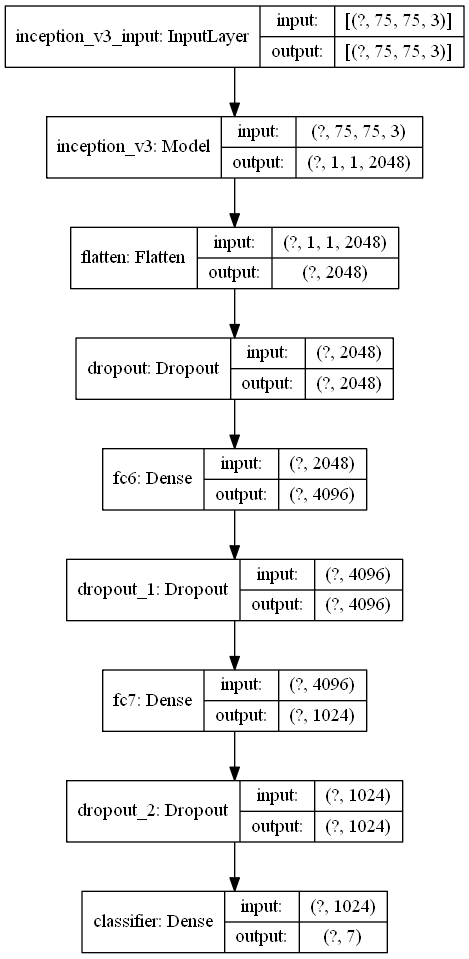

In [ ]:
from IPython.display import Image
from tensorflow.keras.utils import plot_model

plot_model(model, to_file="convnet.png", show_shapes=True, show_layer_names=True)
Image(filename="convnet.png")

In [ ]:
def f1_score(y_true, y_pred):  # taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [ ]:
chk_path = "ferNet.h5"
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(
    filepath=chk_path, save_best_only=True, verbose=1, mode="min", moniter="val_loss"
)

earlystop = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=3, verbose=1, restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=6, verbose=1, min_delta=0.0001
)

rlrop = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    mode="max",
    factor=0.5,
    patience=10,
    min_lr=0.00001,
    verbose=1,
)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger("training.log")
callbacks = [rlrop]

In [ ]:
optim = tf.keras.optimizers.Adam(
    lr=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0
)
sgd = tf.keras.optimizers.SGD(
    lr=SGD_LEARNING_RATE, momentum=0.9, decay=SGD_DECAY, nesterov=True
)

model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=200,
    verbose=1,
    callbacks=callbacks,
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 359 steps, validate for 90 steps
Epoch 1/200
359/359 [==============================] - 42s 117ms/step - loss: 2.2133 - accuracy: 0.2432 - val_loss: 3.2319 - val_accuracy: 0.2390
Epoch 2/200
359/359 [==============================] - 33s 92ms/step - loss: 1.8469 - accuracy: 0.2498 - val_loss: 1.8358 - val_accuracy: 0.2461
Epoch 3/200
359/359 [==============================] - 35s 97ms/step - loss: 1.8181 - accuracy: 0.2497 - val_loss: 1.8016 - val_accuracy: 0.2513
Epoch 4/200
359/359 [==============================] - 36s 100ms/step - loss: 1.8047 - accuracy: 0.2492 - val_loss: 1.7922 - val_accuracy: 0.2494
Epoch 5/200
359/359 [==============================] - 37s 102ms/step - loss: 1.7971 - accuracy: 0.2499 - val_loss: 1.8142 - val_accuracy: 0.2320
Epoch 6/200
359/359 [==============================] - 38s 105ms/step - loss: 1.7878 - accuracy: 0.2523 - val_loss: 1.8927 - val_accuracy: 0.2592
Epoch 7/200
359/359 [============

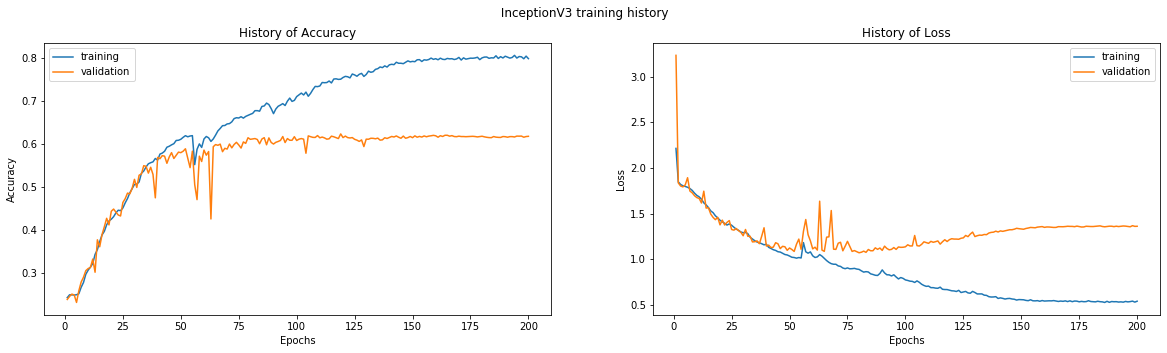

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle(" InceptionV3 training history ")

ax1.plot(range(1, len(acc) + 1), acc)
ax1.plot(range(1, len(val_acc) + 1), val_acc)
ax1.set_title("History of Accuracy")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend(["training", "validation"])

ax2.plot(range(1, len(loss) + 1), loss)
ax2.plot(range(1, len(val_loss) + 1), val_loss)
ax2.set_title("History of Loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend(["training", "validation"])

In [ ]:
model.evaluate(test_dataset)

  ...
    to  
  ['...']
113/113 [==============================] - 3s 30ms/step - loss: 1.3330 - accuracy: 0.6258


[1.333009192901375, 0.6258011]

In [ ]:
model.save('InceptionV3-Model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: InceptionV3-Model\assets


# Ensemble

In [ ]:
!gdown -qq https://drive.google.com/file/d/1twBcSkpxbVRIGoVmmaRdu6ejPHlR9UDs/view?usp=sharing --fuzzy

baseline = Sequential()
# Conv Block 1
baseline.add(Conv2D(64, (3, 3), padding="same", input_shape=(48, 48, 1)))
baseline.add(BatchNormalization())
baseline.add(Activation("relu"))
baseline.add(MaxPooling2D(pool_size=(2, 2)))
baseline.add(Dropout(0.25))

# Conv Block 2
baseline.add(Conv2D(128, (5, 5), padding="same"))
baseline.add(BatchNormalization())
baseline.add(Activation("relu"))
baseline.add(MaxPooling2D(pool_size=(2, 2)))
baseline.add(Dropout(0.25))

# Conv Block 3
baseline.add(Conv2D(512, (3, 3), padding="same"))
baseline.add(BatchNormalization())
baseline.add(Activation("relu"))
baseline.add(MaxPooling2D(pool_size=(2, 2)))
baseline.add(Dropout(0.25))

# Conv Block 4
baseline.add(Conv2D(512, (3, 3), padding="same"))
baseline.add(BatchNormalization())
baseline.add(Activation("relu"))
baseline.add(MaxPooling2D(pool_size=(2, 2)))
baseline.add(Dropout(0.25))

baseline.add(Flatten())

# Fully connected Block 1
baseline.add(Dense(256))
baseline.add(BatchNormalization())
baseline.add(Activation("relu"))
baseline.add(Dropout(0.25))

# Fully connected Block 2
baseline.add(Dense(512))
baseline.add(BatchNormalization())
baseline.add(Activation("relu"))
baseline.add(Dropout(0.25))

baseline.add(Dense(7, activation="softmax"))

baseline.load_weights("./baseline.h5")
baseline.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])
baseline_acc = baseline.evaluate(test_set)[1]

113/113 [==============================] - 13s 19ms/step - loss: 1.0052 - accuracy: 0.6839


## Resnet18

In [ ]:
!gdown -qq https://drive.google.com/file/d/1iU2x--Cqov6tTXxEDUfNHnMSHF7CdO_Q/view?usp=sharing --fuzzy
!unzip resnet18.zip -d ./model

Archive:  resnet18.zip
   creating: ./model/assets/
  inflating: ./model/keras_metadata.pb  
  inflating: ./model/saved_model.pb  
   creating: ./model/variables/
  inflating: ./model/variables/variables.data-00000-of-00001  
  inflating: ./model/variables/variables.index  


In [ ]:
resnet18 = tf.keras.models.load_model('model')
resnet18_acc = resnet18.evaluate(test_set_rgb)[1]

113/113 [==============================] - 4s 22ms/step - loss: 1.1730 - accuracy: 0.6425


## VGGFACE

In [ ]:
!gdown -qq https://drive.google.com/file/d/13PXmuTjTXA6UmdjzNuCSSwR4ia6mtF0F/view?usp=sharing --fuzzy
!unzip vgg_face.zip -d ./model1

Archive:  vgg_face.zip
   creating: ./model1/tmp/tf_save/
   creating: ./model1/tmp/tf_save/variables/
  inflating: ./model1/tmp/tf_save/variables/variables.data-00000-of-00001  
  inflating: ./model1/tmp/tf_save/variables/variables.index  
   creating: ./model1/tmp/tf_save/assets/
  inflating: ./model1/tmp/tf_save/keras_metadata.pb  
  inflating: ./model1/tmp/tf_save/saved_model.pb  


In [ ]:
vggface = tf.keras.models.load_model('model1/tmp/tf_save')
vggface_acc = vggface.evaluate(test_set_224)[1]

113/113 [==============================] - 39s 299ms/step - loss: 0.9142 - accuracy: 0.6765 - precision: 0.7734 - recall: 0.5734 - auc: 0.9306


## Ensembling

In [ ]:
from sklearn.metrics import accuracy_score
model_list = [baseline, resnet18, vggface]

def ensemble():
  y_predict = np.zeros((len(model_list),7178,7))

  y_predict[0,:,:] = model_list[0].predict(test_set)
  y_predict[1,:,:] = model_list[1].predict(test_set_rgb)
  y_predict[2,:,:] = model_list[2].predict(test_set_224)
  y_predict = np.sum(y_predict, axis=0)
  y_predict = np.argmax(y_predict, axis=1)
  y_true = test_set.labels
  return accuracy_score(y_true,y_predict)

In [ ]:
ensemble()

0.7024240735580942

The final accuracy after ensembling 3 model is 70.24%, which is higher than all three individual model accuracies.